In [1]:
import numpy as np
import pandas as pd
import IPython

#Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# sklearn utilities
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import robust_scale

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})

In [3]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})

In [4]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)

In [5]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.rename(columns={"COUNTY": "fips"})

In [6]:
education = pd.read_csv('Education.csv')
education = education.rename(columns={"FIPS Code": "fips", 
                            "Less than a high school diploma, 2010-2014": "< HS",
                            "High school diploma only, 2010-2014":"HS", 
                            "Some college or associate's degree, 2010-2014": "Some College",
                            "Bachelor's degree or higher, 2010-2014": "Bachelors",
                            "Percent of adults with less than a high school diploma, 2010-2014" : "% < HS",
                            "Percent of adults with a high school diploma only, 2010-2014" : "% HS",
                            "Percent of adults completing some college or associate's degree, 2010-2014" : "% Some College",
                            "Percent of adults with a bachelor's degree or higher, 2010-2014" : "% Bachelors"})

education = education.drop(["State", "Area name"], axis=1)
education.head(3)

,fips,< HS,HS,Some College,Bachelors,% < HS,% HS,% Some College,% Bachelors
0,0,28587748.0,58440600.0,60821634.0,61206147.0,13.7,28.0,29.1,29.3
1,1000,524368.0,999761.0,951960.0,741813.0,16.3,31.1,29.6,23.1
2,1001,5012.0,12139.0,11132.0,7950.0,13.8,33.5,30.7,21.9


In [7]:
def new_normal(table):
    normal = robust_scale(table)
    return normal

In [92]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df = df.merge(county_cases, how="left", on="fips")

df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
# df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
# df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
# df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
# df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
# df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
# df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
# df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
# df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
# df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']

df = df.merge(education, how="left", on="fips")
df['% < HS']  = df['% < HS'] / 100
df['% HS'] = df['% HS'] / 100
df['% Some College'] = df['% Some College'] / 100
df['% Bachelors'] = df['% Bachelors'] / 100

df.insert(0, 'Ones', 1)

In [93]:
column_titles =  ['POPESTIMATE2019', 'NEVER',
                  'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'AREA', 
                  'POP_DEN', 'POP_DENxALWAYS', '< HS', 'HS', 'Some College',
                  'Bachelors', '% < HS', '% HS', '% Some College', '% Bachelors']

new_df = df.reindex(columns=column_titles)
normal_all = new_normal(new_df)
normal_df = pd.DataFrame(normal_all)
normal_df.columns = column_titles
normal_df['fips'] = df['fips']
normal_df = normal_df.merge(county_cases, how="left", on="fips")
column_titles = ['fips','cases','deaths','POPESTIMATE2019', 'NEVER',
                 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS',
                 '% < HS', '% HS', '% Some College', '% Bachelors']
                 #'< HS', 'HS', 'Some College','Bachelors']
    
                 

# ['fips','cases','deaths','POPESTIMATE2019', 'NEVER',
#  'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'AREA', 'cases',
#  'deaths', 'POP_DEN', 'POP_DENxALWAYS', '< HS', 'HS', 'Some College',
#  'Bachelors', '% < HS', '% HS', '% Some College', '% Bachelors']

normal_df = normal_df.reindex(columns=column_titles)

In [94]:
# df['cases'] = np.log(df['cases'])
df['cases'].describe()

# index = df[(df['cases'] >= 20000)|(df['cases'] <= 0)].index
# df.drop(index, inplace=True)
# normal_df.drop(index, inplace=True)
# df['cases'].describe()



count      3128.000000
mean       2649.581202
std       10055.894415
min           1.000000
25%         209.750000
50%         602.500000
75%        1692.250000
max      299760.000000
Name: cases, dtype: float64

In [95]:
# Split Data
normal_svm_df = normal_df.drop(['cases','fips'], axis=1)
cols = df.shape[1]

X = normal_svm_df # iloc slicing function 
y = df['cases']

In [96]:
#X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)
print(y.shape)

(3128, 11)
(3128,)


In [97]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.2,  random_state=0) 

ytrain = np.log(ytrain)
ytest = np.log(ytest)

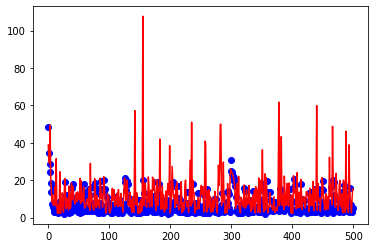

In [14]:
# Runs and plots the performance of a model with the same parameters from before (and a learning rate of 10000), 
# but now with an activation function (Relu)

#Defines linear regression model and its structure
model = Sequential()
model.add(Dense(1, input_shape=(11,), activation='relu'))

#Compiles model
model.compile(Adam(lr=.01), 'mean_squared_error')

#Fits model
history = model.fit(xtrain, ytrain, epochs = 500, validation_split = 0.1,verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.show()

In [15]:
# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(ytrain, ytrain_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(ytest, ytest_pred)))

The R2 score on the Train set is:	-4.555
The R2 score on the Test set is:	-4.743


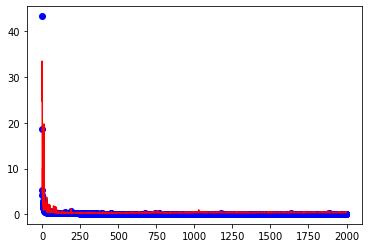

In [16]:
# Defines "deep" model and its structure w/out early stopping
model = Sequential()
model.add(Dense(13, input_shape=(11,), activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(1,))
model.compile(Adam(lr=0.003), 'mean_squared_error')

# Runs model for 2000 iterations and assigns this to 'history'
history = model.fit(xtrain, ytrain, epochs = 2000, validation_split = 0.2, verbose = 0)

# Plots 'history'
# history_dict=history.history
# loss_values = history_dict['loss']
# val_loss_values=history_dict['val_loss']
# plt.plot(loss_values,'bo',label='training loss')
# plt.plot(val_loss_values,'r',label='training loss val')

In [104]:
# Defines "deep" model and its structure w/ early stopping

model = Sequential()
model.add(Dense(32, input_shape=(11,), activation='relu', name='Input'))
model.add(Dense(13, activation='relu', name='H1'))
model.add(Dense(13, activation='relu', name='H2'))
model.add(Dense(13, activation='relu', name='H3'))
model.add(Dense(13, activation='relu', name='H4'))
model.add(Dense(13, activation='relu', name='H5'))
model.add(Dense(6, activation='relu', name='H6'))
model.add(Dense(1, name='Output'))
model.compile(Adam(lr=0.0005), 'mean_squared_error', metrics=['mae'])
#print(model.summary())
plot_model(model, to_file='model.png')

# Pass several parameters to 'EarlyStopping' function and assigns it to 'earlystopper'
earlystopper = EarlyStopping(monitor='loss', min_delta=0, patience=30, verbose=1, mode='auto')

# Fits model over 2000 iterations with 'earlystopper' callback, and assigns it to history
history = model.fit(xtrain, ytrain, epochs = 1000, validation_split = 0.2, shuffle = False, verbose = 0, 
                    callbacks = [earlystopper])
evals = model.evaluate(xtrain, ytrain)

# Plots 'history'
# history_dict=history.history
# loss_values = history_dict['loss']
# val_loss_values=history_dict['val_loss']
# plt.plot(loss_values,'bo',label='training loss')
# plt.plot(val_loss_values,'r',label='training loss val')

# Runs model with its current weights on the training and testing data

print(evals)

Epoch 00814: early stopping
79/79 [==============================] - 0s 985us/step - loss: 0.1864 - mae: 0.3131
[0.1863914132118225, 0.31311172246932983]


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


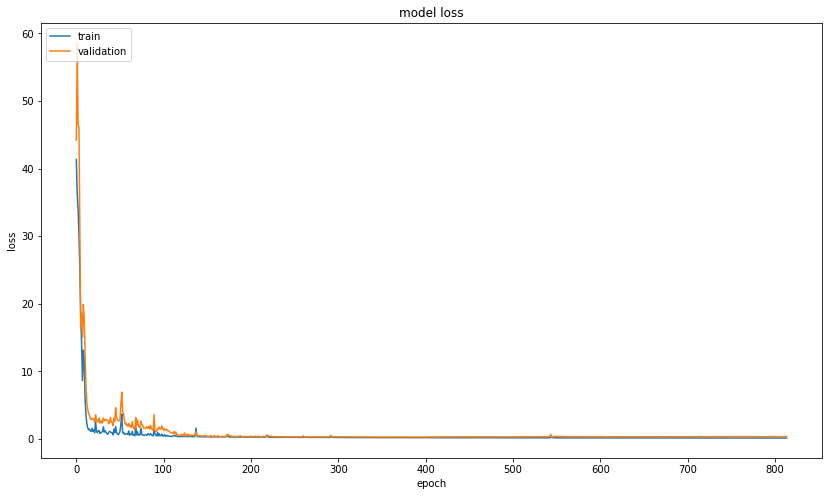

The MSE on the Test set is:		0.186
The R2 score on the Test set is:	0.853


In [105]:
print(history.history.keys())
# "Loss"
fig, ax = plt.subplots(figsize=[14,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)

# Calculates and prints r2 score of training and testing data
# print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(ytrain, ytrain_pred)))
print("The MSE on the Test set is:\t\t{:0.3f}".format(evals[0]))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(ytest, ytest_pred)))

/Users/matthewzahar/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


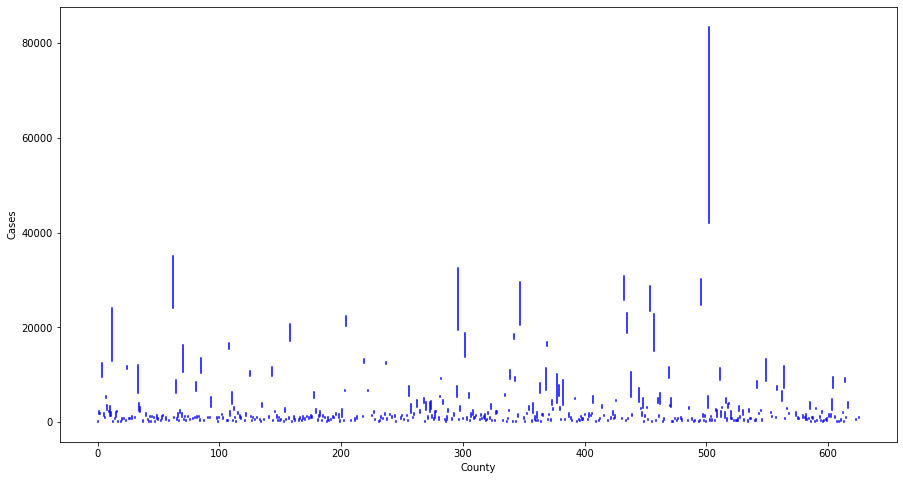

In [106]:
fig, ax = plt.subplots(figsize=(15,8))
ydf = pd.DataFrame(ytest)
for i in range(len(xtest.index)):
    plt.plot([i,i], [np.exp(ytest_pred[i]),np.exp(ydf.iloc[i,0])], 'b') 
plt.ylabel('Cases')
plt.xlabel('County')
plt.show()

In [89]:
# plt.plot(ytrain, ytrain_pred,'*r')
# plt.plot(ytest, ytest_pred, '*g')

# for i in range(400,1000):
#     plt.plot(i/100,i/100,'*y')
# plt.figure()